In [1]:
import matplotlib.pyplot as plt
import numpy as np

# helper function to plot images
def plot_images(images, nrows, ncols, scale=2):
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(scale * ncols, scale * nrows)
    )  # Create grid of subplots

    for i, ax in enumerate(axes.flat):
        norm_img = (
            (images[i] - np.min(images)) / (np.max(images) - np.min(images)) * 255
        ).astype(int)
        ax.imshow(norm_img, cmap="gray")
        ax.axis("off")

    plt.tight_layout()
    # plt.show()

# helper function to plot bases
def plot_bases(A, scale=1, nrows=8, ncols=8):
    """
    Plots bases.

    Args:
        A: Basis function matrix, assumes basis function is square.

    Returns:
        None
    """
    L, M = A.shape
    sz = np.sqrt(L).astype(int)  # Ensure integer size for indexing

    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(scale * ncols, scale * nrows)
    )  # Create grid of subplots

    for i, ax in enumerate(axes.flat):
        image = np.reshape(A[:, i], (sz, sz))
        image = image[:, :, np.newaxis]
        norm_img = (image) / (np.max(A[:, i]))
        ax.imshow(norm_img, cmap="gray", vmin=-1, vmax=1)
        ax.axis("off")

    plt.tight_layout()

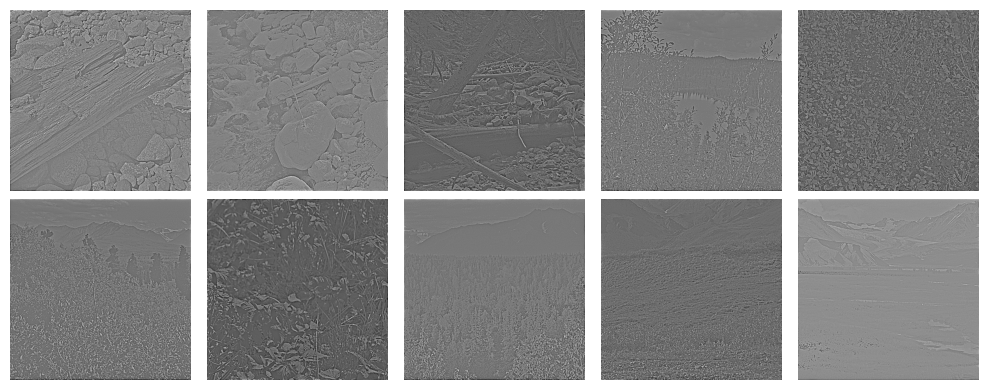

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# seed rng for consistent results
np.random.seed(1)

# load images
images = np.load("images.npy")

# plot images 
plot_images(images, nrows=2, ncols=5)

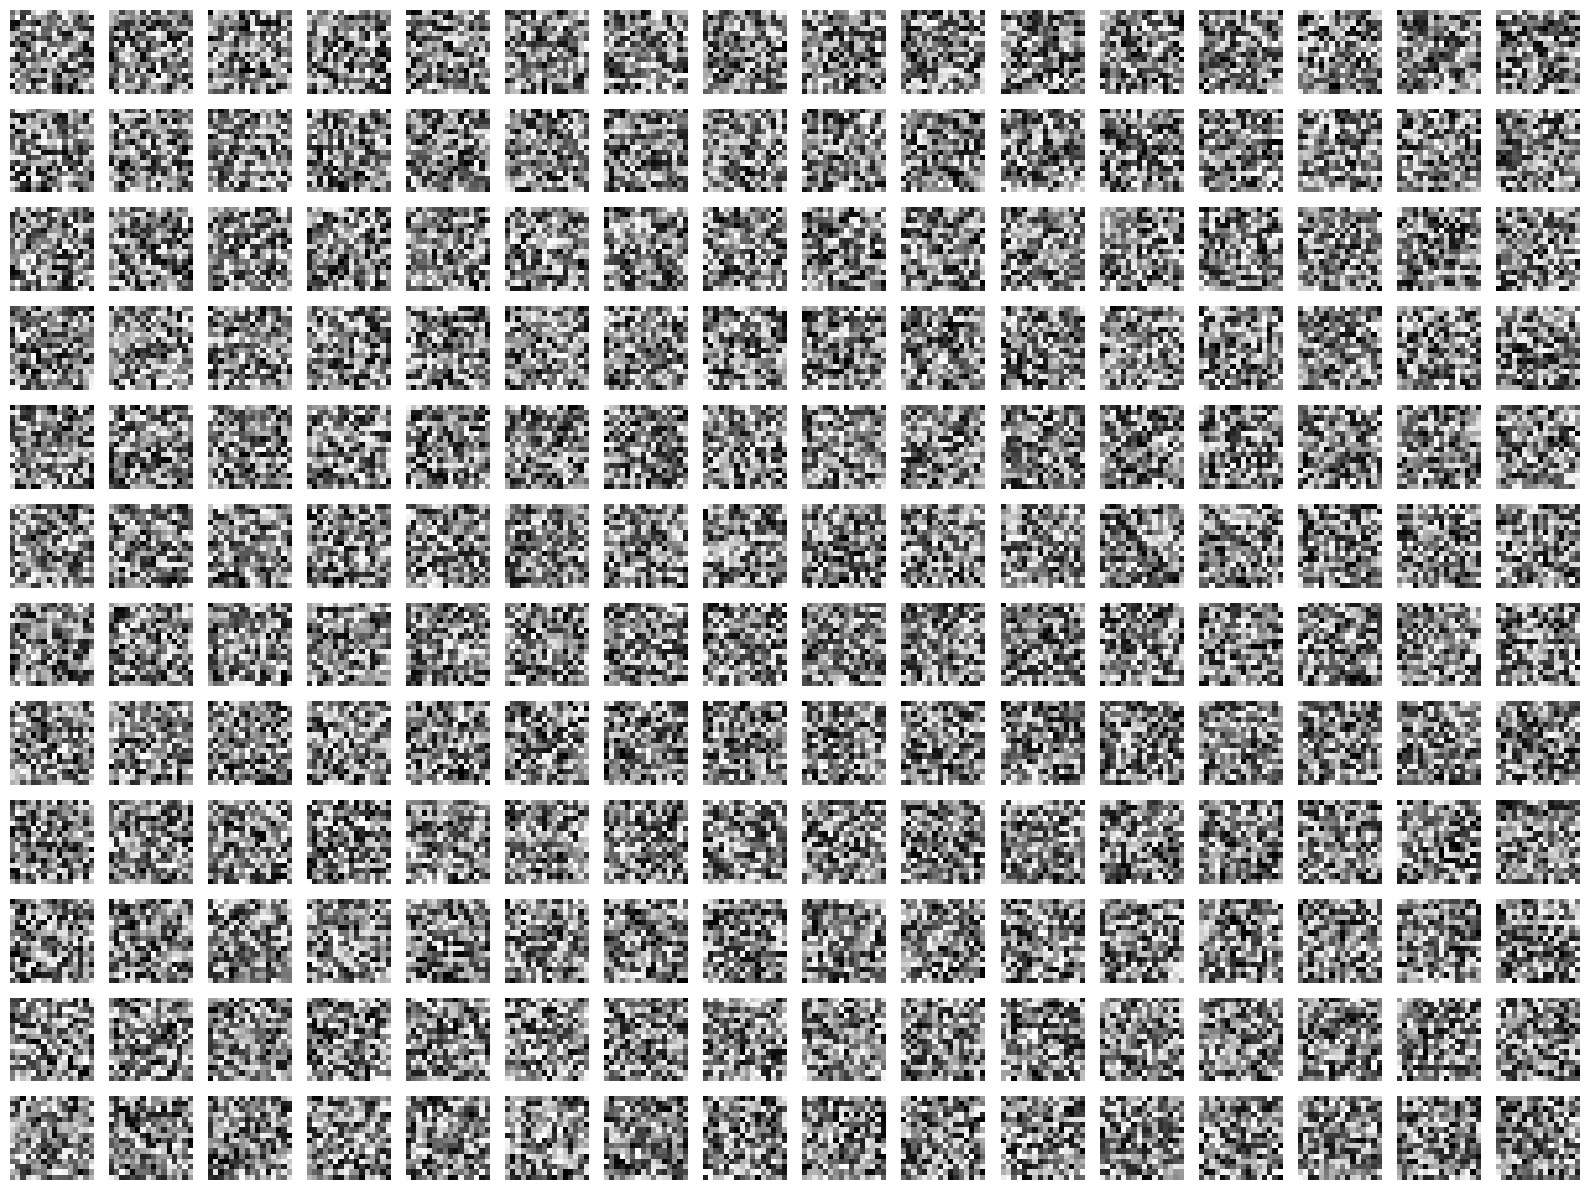

In [3]:
# Define the basis matrix, a 64 x 64 matrix where each column is a basis vector
L = 256
M = 192
A = np.random.rand(L, M) - 0.5
A = A @ np.diag(1./np.sqrt(np.sum(A*A, axis=0)))
assert np.allclose(np.sqrt(np.sum(A * A, 0)),1) # assert that each basis is of length 1
plot_bases(A, nrows=12, ncols=16)

In [4]:
import matplotlib
%matplotlib inline

import numpy as np
from tqdm import trange
from scipy.optimize import minimize

import pylab as pl
from IPython import display

# parameters for training
num_trials = 10000
batch_size = 100

num_images = images.shape[0]
image_size = images.shape[1]
BUFF = 4

sz = int(np.sqrt(L))

eta = 1
noise_var = 0.01
beta = 2.2
sigma = 0.316
tol = .01

VAR_GOAL = 0.1
S_var = VAR_GOAL * np.ones(M)
var_eta = 0.001
alpha = 0.02
gain = np.sqrt(np.sum(A**2, axis=0)).T

display_every = 10000

In [5]:
def sparse(x):
    return np.log(1.0 + x**2)

def sparse_prime(x):
    return 2 * x / (1.0 + x**2)

def cost_fxn(coef, basis, image, lambda_, beta, sigma):
    pres_info = np.sum(np.square(image-(basis @ coef)))
    pres_cost = 0.5 * lambda_ * pres_info
    sparse_cost = beta * np.sum(sparse(coef/sigma))
    return sparse_cost + pres_cost

def cost_jac(coef, basis, image, lambda_, beta, sigma):
    AtA = basis.T @ basis
    Atx = basis.T @ image
    bos = beta/sigma 
    M = len(Atx)

    jac_recon = lambda_ * (AtA @ coef -Atx)
    jac_sparse = bos*sparse_prime(coef/sigma)
    return jac_sparse + jac_recon

def cgf_fit(basis, image, noise_var, beta, sigma, tol=0.001):
    max_iter = 100

    x0 = basis.T @ image
    basis_norm = np.sum(basis**2, axis=0).T
    x0 = x0/basis_norm

    lambda_ = 1/noise_var

    res = minimize(cost_fxn, x0, args=(basis, image, lambda_, beta, sigma), method="CG", jac=cost_jac, tol=tol, options={"maxiter": max_iter})
    return res.x

In [6]:
# verify that the gradient computation is correct
from scipy.optimize import check_grad

# choose an image for this batch at random
im_id = np.floor(num_images * np.random.rand()).astype(int)
this_image = images[im_id]

# extract subimages at random from this image to make data vector X
X = np.zeros((L, 1))
i = 0
r = BUFF + np.ceil((image_size - sz - 2 * BUFF) * np.random.rand()).astype(int) - 1
c = BUFF + np.ceil((image_size - sz - 2 * BUFF) * np.random.rand()).astype(int) - 1
X[:, i] = this_image[r : r + sz, c : c + sz].T.reshape(L)

# check gradient -- assert that error is less than 1e-3
x0 = A.T @ X[:, i]
err = check_grad(cost_fxn, cost_jac, x0, A, X[:, i], 1/noise_var, beta, sigma) 

print(err)

assert err < 1e-2

2.1694968067374743e-05


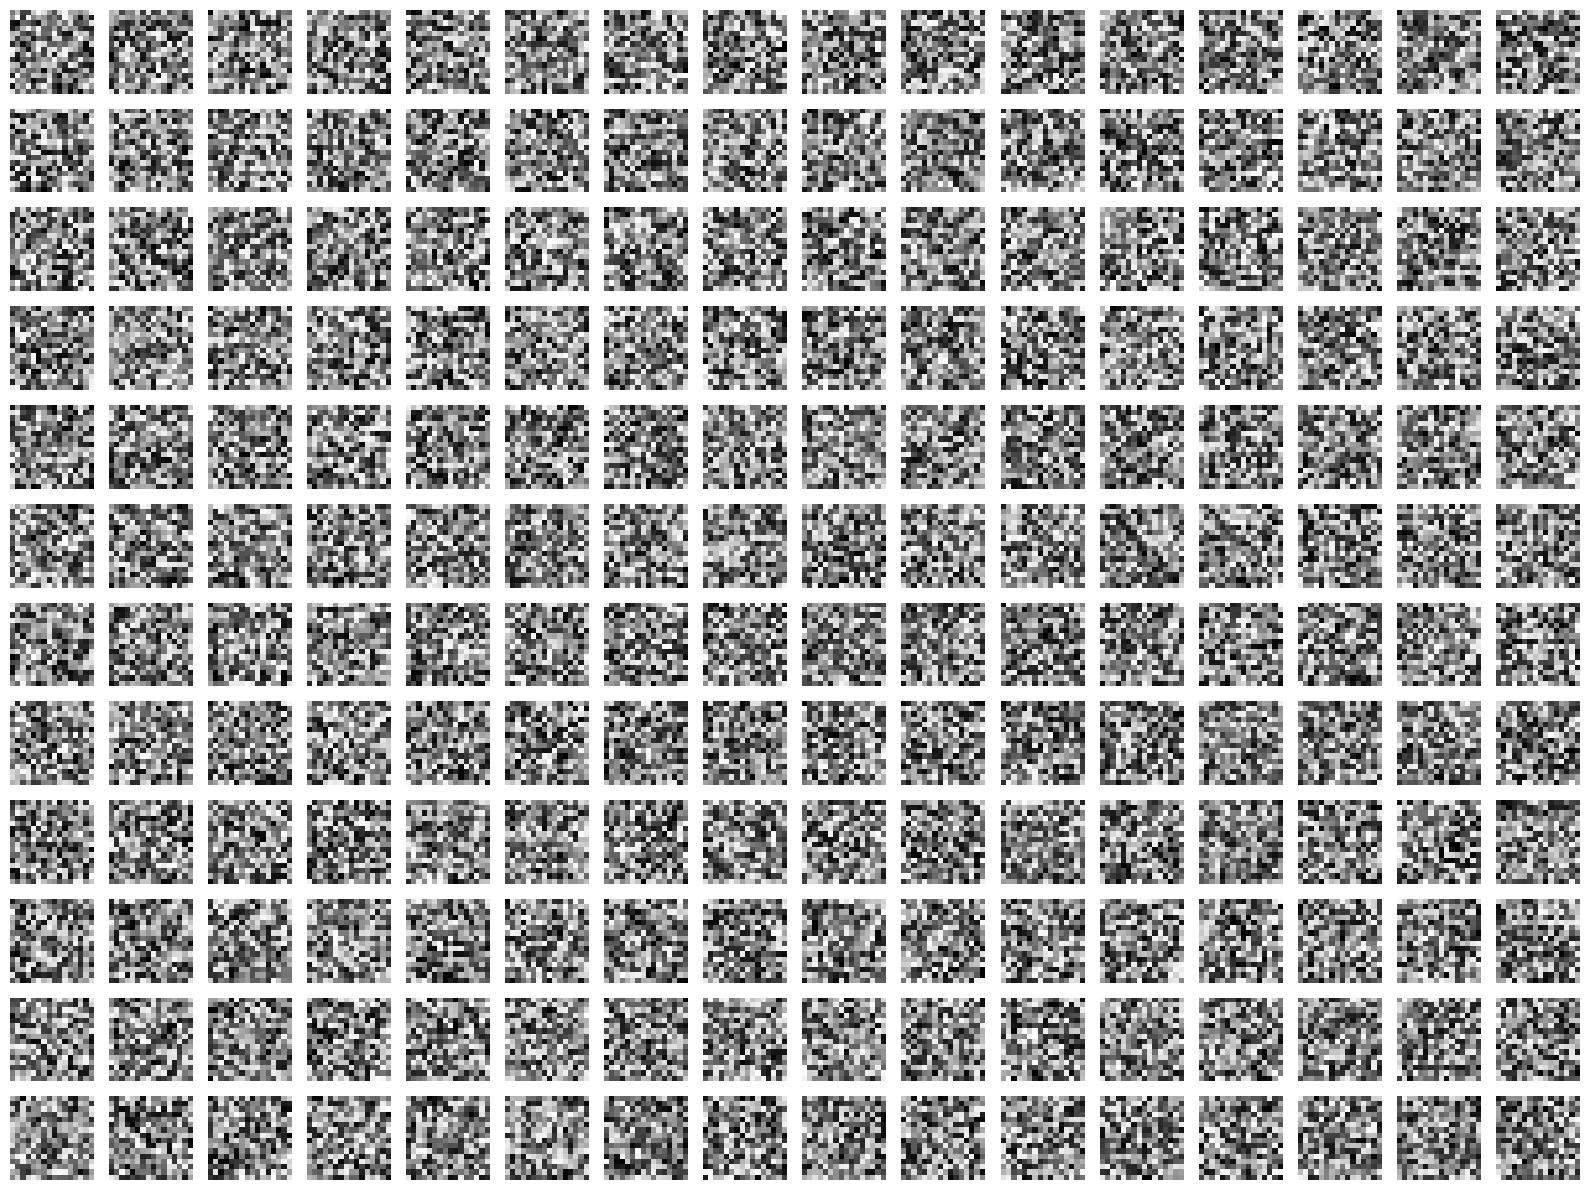

100%|██████████| 10000/10000 [13:01:09<00:00,  4.69s/it] 


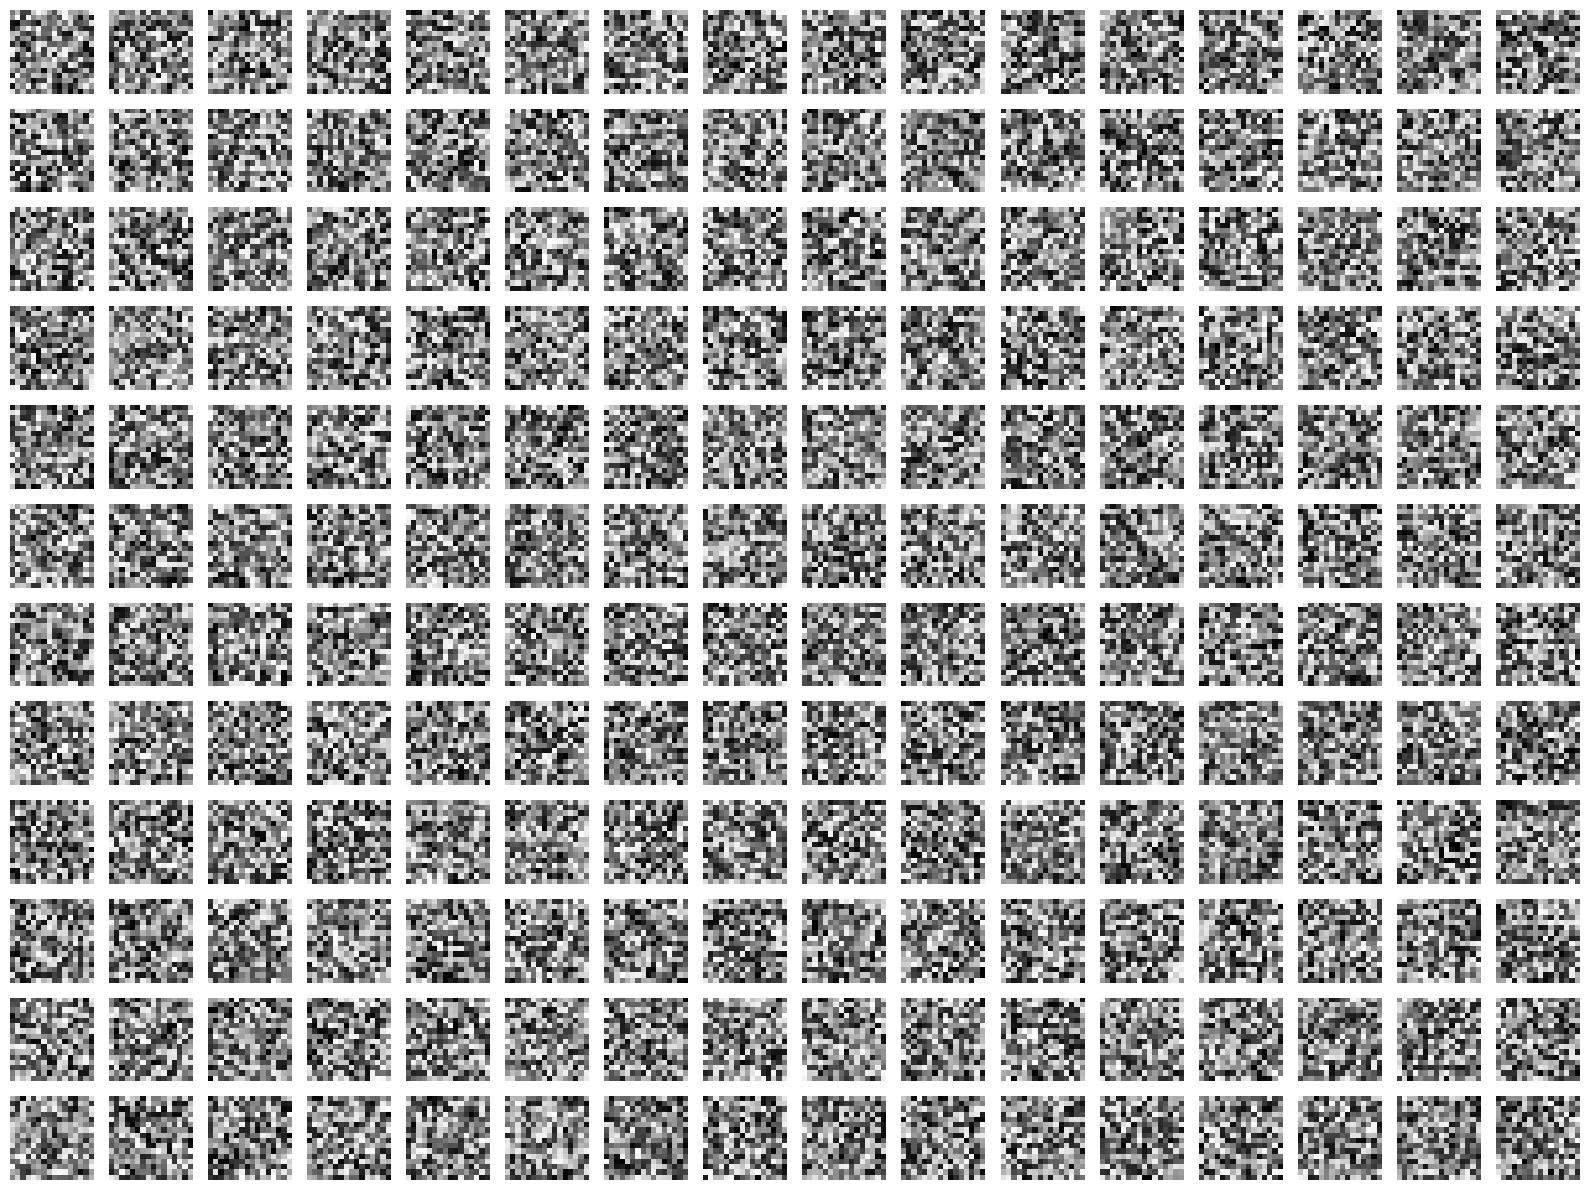

In [7]:
from tqdm import trange
# train the network
for t in trange(num_trials):
    # choose an image for this batch at random
    im_id = np.floor(num_images * np.random.rand()).astype(int)
    this_image = images[im_id]

    # extract subimages at random from this image to make data vector X
    X = np.zeros((L, batch_size))
    S = np.zeros((M, batch_size))
    E = np.zeros((L, batch_size))
    for i in range(batch_size):
        r = BUFF + np.ceil((image_size - sz - 2 * BUFF) * np.random.rand()).astype(int) - 1
        c = BUFF + np.ceil((image_size - sz - 2 * BUFF) * np.random.rand()).astype(int) - 1
        X[:, i] = this_image[r : r + sz, c : c + sz].T.reshape(L)
        # Calculate coefficients for these data via conjugate gradient routine
        S[:, i] = cgf_fit(A, X[:, i], noise_var, beta, sigma, tol)

    # Residual 
    E = X - (A @ S)

    # Update bases
    dA = np.zeros((L, M))
    for i in range(batch_size):
        dA = dA + (E[:, i][:, np.newaxis] @ S[:, i][np.newaxis, :])
    dA = dA/batch_size
    A += eta * dA

    # Normalize bases to match desired output variance
    for i in range(batch_size):
        S_var = (1 - var_eta) * S_var + var_eta * S[:, i] * S[:, i]
    gain = gain * (np.power((S_var / VAR_GOAL),alpha))
    normA = np.sqrt(np.sum(A*A, axis=0))

    for i in range(M):
        A[:, i] = gain[i] * A[:, i] / normA[i]

    if t % display_every == 0:
        plot_bases(A,nrows=12, ncols=16)
        display.clear_output(wait=True)
        display.display(pl.gcf())

In [8]:
np.save("basis_trained.npy", A)

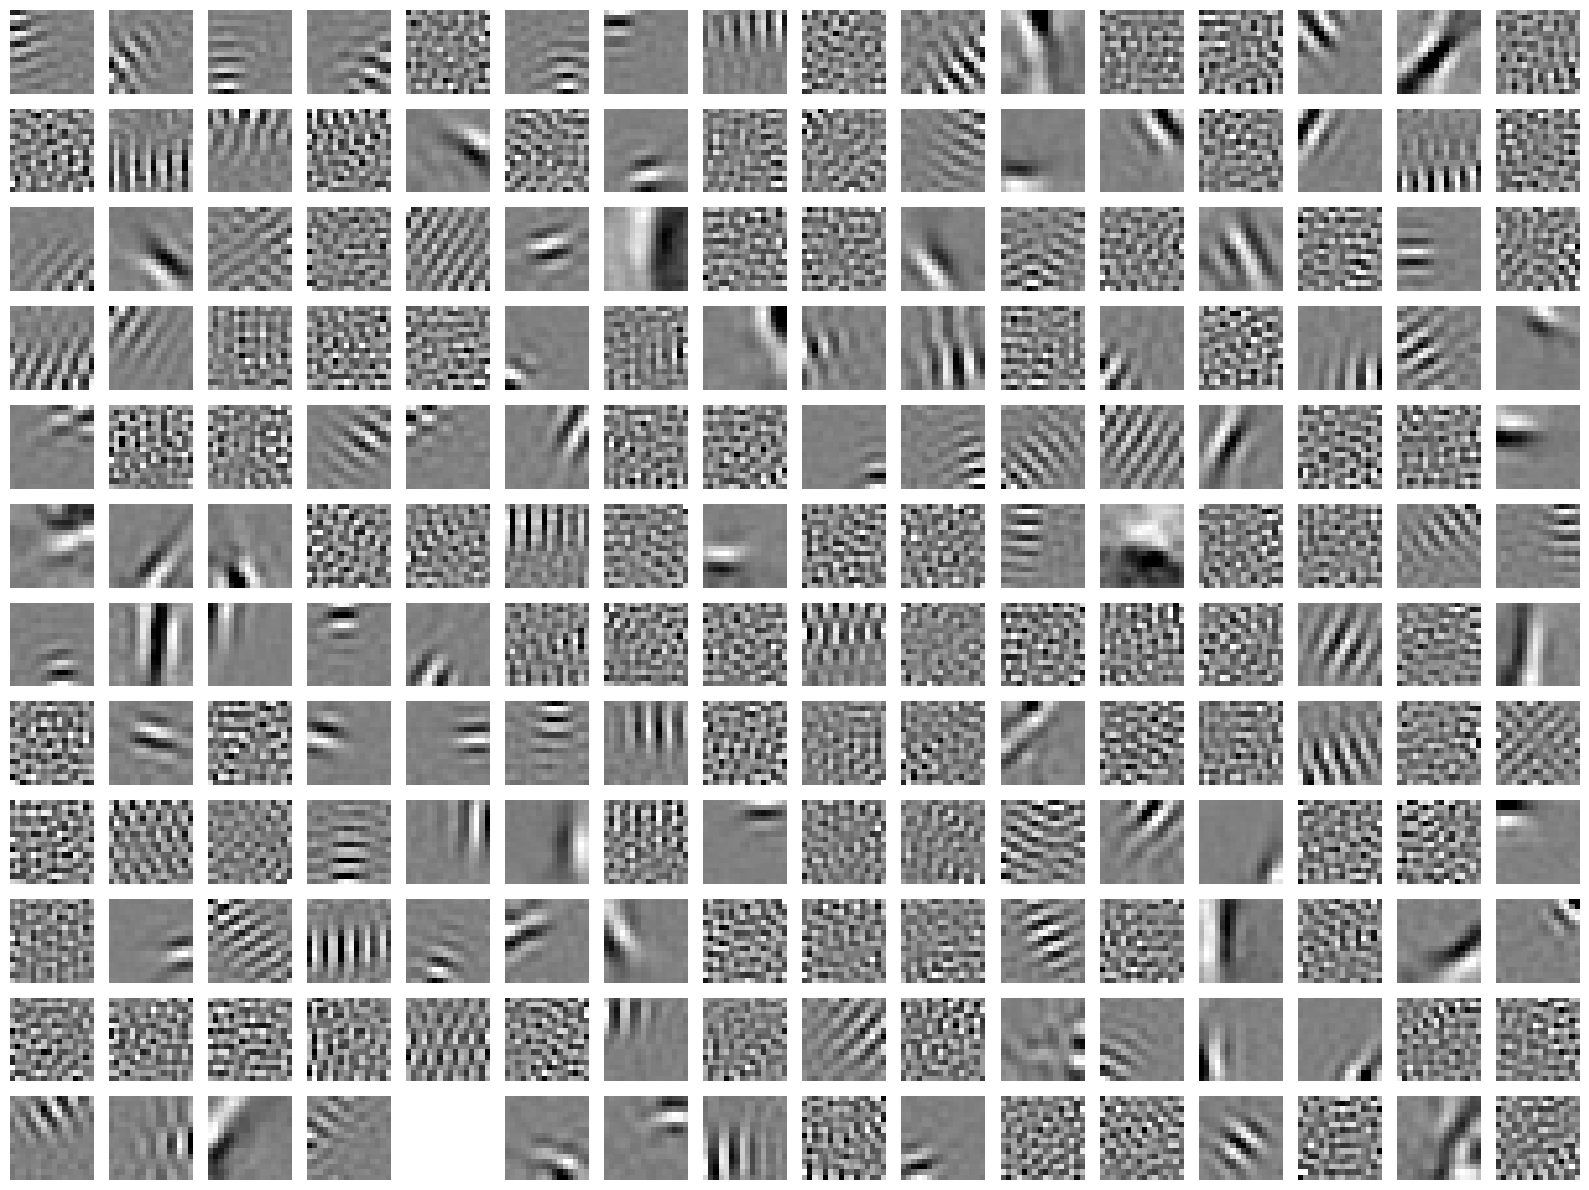

In [9]:
A_trained = np.load("basis_trained.npy")
plot_bases(A_trained, nrows=12, ncols=16)